In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        # Dynamically calculate the flattened size
        self.flatten_size = None
        self.fc1 = nn.Linear(0, 64)  # Placeholder, will be initialized in forward
        self.fc_mean = nn.Linear(64, latent_dim)
        self.fc_log_var = nn.Linear(64, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        if self.flatten_size is None:
            self.flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flatten_size, 64)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 8 * 16)
        self.conv2d_t1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2d_t2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2d_t3 = nn.ConvTranspose2d(32, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, z):
        z = F.relu(self.fc(z))
        z = z.view(-1, 128, 8, 16)  # Reshape to match the output of the encoder's last conv layer
        z = F.relu(self.conv2d_t1(z))
        z = F.relu(self.conv2d_t2(z))
        reconstruction = torch.sigmoid(self.conv2d_t3(z))
        return reconstruction

class VAE(nn.Module):
    def __init__(self, input_channels, latent_dim, output_channels):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim, output_channels)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        return self.decoder(z), mean, log_var

In [2]:
# Parameters
input_channels = 1   # Assuming single-channel spectrogram
output_channels = 1  # Output also single-channel
latent_dim = 2
spectrogram_size = (64, 128)  # Example spectrogram size

In [3]:
# Loss function
def vae_loss(recon_x, x, mean, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return BCE + KLD

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Lione\AppData\Local\Temp\ipykernel_15800\3615115010.py:6: SyntaxWarning: invalid escape sequence '\d'
  data = pd.read_csv('.\datasets\MobiAct_Dataset_v2.0\Annotated Data\BSC\BSC_1_1_annotated.csv')


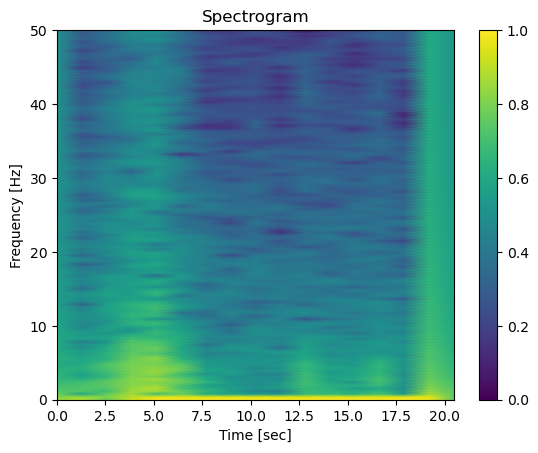

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import stft

data = pd.read_csv('.\datasets\MobiAct_Dataset_v2.0\Annotated Data\BSC\BSC_1_1_annotated.csv')

def create_spectrogram(data):
    fs = 100  # Sample rate in Hz
    window = 'hann'
    window_length = 256  # Length of each segment
    noverlap = 128  # Overlap between windows
    nfft = 256  # Number of points in FFT

    # Select accelerometer data
    acc_data = data[['acc_x', 'acc_y', 'acc_z']].values

    # STFT
    f, t, Zxx = stft(acc_data[:, 0], fs=fs, window=window, nperseg=window_length, noverlap=noverlap, nfft=nfft)

    # Convert to dB
    spectrogram = np.log(np.abs(Zxx) + 1e-8)  # Adding a small number to avoid log(0)

    # Normalize
    spectrogram = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))
    
    return spectrogram, f, t

test, f, t = create_spectrogram(data)
# Plot
plt.pcolormesh(t, f, test, shading='gouraud')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()
